# Analysis of financial time series data via an LSTM neural network, an ARIMA model, a Random Forrest and an ensemble thereof

A **time-series** is an ordered sequence of observations the temporal dependence of which reveals trend, seasonality and shock propagation. The goal of time series analysis is to investigate the path of observations of time series and to build models to describe the structure of data and then to predict the future values of the series. When the observations are asset prices, returns or liquidity metrics it becomes a **financial time series**, forming the empirical base of valuation, risk control, and policy surveillance.

**Linear models** such as **ARIMA** offer statistical transparency but assume stationarity and short-range memory, constraints routinely violated by markets that exhibit regime shifts, volatility clustering and non-linear feedback. **Deep-learning approaches**, especially **recurrent neural networks (RNNs)**, discard these assumptions by learning high-order, non-linear mappings directly from data.

The **Long Short-Term Memory (LSTM)** architecture augments RNNs with gated cells that preserve information over hundreds of lags, enabling it to capture dynamics that ARIMA cannot without manual lag inflation or hybrid extensions (like an ARIMA-GARCH stack). (Note that GARCH stands f) Empirical studies show well-regularised LSTMs deliver lower forecast error and more coherent risk estimates than such hybrid models, particularly when heterogeneous signals (i.e. information beyond the raw price series like order flow, macro news, technical factors etc.) are fed into the network. Nonetheless, their performance hinges on ample data, robust cross-validation and strict out-of-sample testing.

Despite their limitations, **ARIMA models** remain foundational in time series forecasting due to their interpretability, fast estimation and suitability for short-memory processes. They provide a reliable benchmark and often outperform more complex models on small or well-behaved datasets, especially when domain-specific tuning (e.g. differencing, AIC selection etc.) is applied.

On the other hand, a **Random Forest** is an ensemble‐learning algorithm that builds a large collection of decision-tree regressors, each trained on a bootstrapped sample of the data and a random subset of input features and averages their predictions to produce a robust, low-variance forecast. In general, Random Forests are fast to fit and can be quickly updated with new trees. When applied to time-series problems, the series is first reframed as a supervised-learning table. The forest then learns non-linear, non-parametric relationships between those engineered features and the next-period price or return, making it popular for financial markets where regimes and interactions shift abruptly. Unlike an **ARIMA model**, which assumes a linear stochastic structure and focuses on capturing autocorrelation with a small set of coefficients, a **Random Forest** makes no stationarity or linearity assumptions.  Moreover, it can be fed by high-dimensional and heterogeneous features coming at the cost of losing interpretability and struggling with long time horizon extrapolation. Compared with an **LSTM network**, the forest is simpler to train, less data-hungry, and immune to vanishing-gradient issues. Yet, it lacks the LSTM’s ability to memorise very long contexts and can be fragile when regime shifts render its fixed lag features obsolete. Another natural shortcoming is that they cannot natively model seasonality and integrate trend explicitly.

Combining models through an **ensemble approach** leverages the complementary strengths of each: ARIMA captures linear, short-run dependencies, LSTM models non-linear, longer-run interactions while the Random forrest maps tree-based non-linearity well. In this notebook, we want to check if this can yield a lower error and a more stable performance than any single method. As well-known ensemble forecasts often improve robustness, reduce overfitting, and yield lower error metrics than either model alone, particularly when model disagreement signals structural shifts or uncertainty. The ensemble chosen here is constructed by simply computing the equally weighted average of the predictions of each approach.

In [80]:
# ===============================================================================================
# === STEP 1: Load libraries / Laden benötigter Bibliotheken ====================================
# ===============================================================================================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor         

# SciPy
from scipy.optimize import curve_fit
from scipy.stats import norm, shapiro, wilcoxon

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping          

# Statsmodels & pmdarima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# ===============================================================================================
# === STEP 2: Load and prepare data / Laden und Vorbereitung der Zeitreihe ======================
# ===============================================================================================
df = pd.read_csv("NKE.csv", parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
df['Close'] = df['Close'].interpolate()
y_raw = df['Close'].values

In [84]:
# ===============================================================================================
# === STEP 3: Detrending for LSTM / Trendbereinigung fürs LSTM ==================================
# ===============================================================================================
# Fit linear trend / Fitten eines linearen Trends
x = np.linspace(0, 1, len(df)).reshape(-1, 1)
lin_model = LinearRegression().fit(x, y_raw)
y_lin_pred = lin_model.predict(x)
r2_lin = lin_model.score(x, y_raw)

# Fit exponential trend / Fitten eines exponentiellen Trends
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

try:
    popt, _ = curve_fit(exp_func, x.ravel(), y_raw, maxfev=10000)
    y_exp_pred = exp_func(x.ravel(), *popt)
    r2_exp = 1 - np.sum((y_raw - y_exp_pred) ** 2) / np.sum((y_raw - y_raw.mean()) ** 2)
except RuntimeError:
    r2_exp = -np.inf  # If fitting fails / Falls das Fitten fehlschlägt

# Choose detrending method based on R² value / Entscheide für eine Trendbereinigungsmethode
r2_threshold = 0.95
if r2_lin >= r2_threshold:
    trend_used, trend = "linear", y_lin_pred
    print("Using linear trend removal / Nutze lineare Trendbereinigung:")
elif r2_exp >= r2_threshold:
    trend_used, trend = "exponential", y_exp_pred
    print("Using exponential trend removal / Nutze exponentielle Trendbereinigung:")
else:
    trend_used, trend = "difference", np.zeros_like(y_raw)
    print("Using first-difference method (no strong lin. or exp. trend) / Nutze erste Differenzmethode")

detrended = y_raw - trend if trend_used != "difference" else np.diff(y_raw, prepend=y_raw[0])

print(f"\nR² (linear):      {r2_lin:.4f}")
print(f"R² (exponential): {r2_exp:.4f}")


# ===============================================================================================
# === ADF Test for Stationarity / ADF-Test auf Stationarität ====================================
# ===============================================================================================
adf_result = adfuller(detrended)
adf_stat, p_val, crit_vals = adf_result[0], adf_result[1], adf_result[4]

print("\n ADF Test Results:")
print("ADF Statistic:", adf_stat)
print("p-value:", p_val)
print("Critical Values:")
for key, value in crit_vals.items():
    print(f"  {key}: {value:.3f}")

if adf_stat < crit_vals["5%"] and p_val < 0.05:
    print("\n The detrended series is stationary.")
else:
    print("\n The detrended series is likely still non-stationary.")

Using exponential trend removal / Nutze exponentielle Trendbereinigung:

R² (linear):      0.6451
R² (exponential): 0.9809

 ADF Test Results:
ADF Statistic: -5.86157398383508
p-value: 3.4006667229714175e-07
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

 The detrended series is stationary.


In [86]:
# ===============================================================================================
# === STEP 4: Split & normalize detrended data / Aufteilung & Normalisierung ====================
# ===============================================================================================
n = len(df)
train_end, val_end = int(0.8 * n), int(0.9 * n)

train_detrended = detrended[:train_end]
val_detrended   = detrended[train_end:val_end]
test_detrended  = detrended[val_end:]

scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train_detrended.reshape(-1, 1)).flatten()
val_norm   = scaler.transform(val_detrended.reshape(-1, 1)).flatten()
test_norm  = scaler.transform(test_detrended.reshape(-1, 1)).flatten()

In [88]:
# ===============================================================================================
# === STEP 5: Create LSTM windows / Erstelle gleitende Fenster ==================================
# ===============================================================================================
number_of_delays = 90

def create_windows(data, n_delays=90):
    X, y = [], []
    for i in range(len(data) - n_delays):
        X.append(data[i:i + n_delays])
        y.append(data[i + n_delays])
    return np.array(X), np.array(y)

X_train, y_train = create_windows(train_norm, number_of_delays)
X_val,   y_val   = create_windows(val_norm,   number_of_delays)
X_test,  y_test  = create_windows(test_norm,  number_of_delays)

print(f"Number of delays: {number_of_delays}")
print(f"Train shape: {X_train.shape}")
print(f"Val   shape: {X_val.shape}")
print(f"Test  shape: {X_test.shape}")

Number of delays: 90
Train shape: (7942, 90)
Val   shape: (914, 90)
Test  shape: (915, 90)


In [90]:
# ===============================================================================================
# === STEP 6: Build and train LSTM model / Konstruktion und Training des LSTM-Modells ===========
# ===============================================================================================
X_train_lstm = X_train.reshape(-1, number_of_delays, 1)
X_val_lstm   = X_val.reshape(  -1, number_of_delays, 1)
X_test_lstm  = X_test.reshape( -1, number_of_delays, 1)

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(number_of_delays, 1)),
    Dropout(0.15),
    LSTM(32),
    Dense(1),
])

lstm_model.compile(optimizer=Adam(learning_rate=5e-4), loss="mse")

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stop],
    verbose=1,
)



# ===============================================================================================
# === STEP 7: LSTM training vs validation loss plot / Evaluation des LSTM-Modells ===============
# ===============================================================================================
plt.figure(figsize=(6.7, 3.3))
plt.plot(history.history["loss"],     label="Training Loss",   linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



# ===============================================================================================
# === STEP 8: LSTM prediction & back-transform / Vorhersagen und Rücktransformation =============
# ===============================================================================================
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
test_trend  = trend[val_end + number_of_delays:] if trend_used != "difference" else y_raw[val_end + number_of_delays:]

y_pred_lstm_usd = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten() + test_trend
y_true_lstm     = df["Close"].iloc[val_end + number_of_delays:].values

rmse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm_usd, squared=False)
r2_lstm   = r2_score(y_true_lstm, y_pred_lstm_usd)

print("\n Results for generalization to test data / Ergebnisse für Generalisierung:")
print(f"  LSTM RMSE : {rmse_lstm:.4f} USD")
print(f"  LSTM R²   : {r2_lstm:.4f}")

lstm_re_df = pd.DataFrame({
    "Date": df["Date"].iloc[val_end + number_of_delays: val_end + number_of_delays + len(y_pred_lstm_usd)],
    "LSTM": y_pred_lstm_usd})
lstm_re_df.to_csv("lstm_preds_retransformed.csv", index=False)
print("Saved LSTM predictions to 'lstm_preds_retransformed.csv'")

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0246 - val_loss: 0.0136
Epoch 2/100
 35/249 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 7.6066e-04

KeyboardInterrupt: 

In [52]:
# ====================================================================================================
# === STEP 9: ARIMA model with identical preprocessing / Training + Vorhersagen des ARIMA Modells=====
# ====================================================================================================
print("\nARIMA grid-search on train_norm data …")
arima_order = pm.auto_arima(
    train_norm,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,
    stepwise=True,
    error_action="ignore",
    suppress_warnings=True,
).order
print(f"  → Selected order: {arima_order}")

model   = ARIMA(train_norm, order=arima_order)
results = model.fit()
print("Initial ARIMA model fit completed.")

for z in val_norm:
    results = results.append([z], refit=False)

first_pred_idx = val_end + number_of_delays
preds_norm = []

for z in test_norm[:number_of_delays]:
    results = results.append([z], refit=False)

for z in test_norm[number_of_delays:]:
    preds_norm.append(results.forecast()[0])
    results = results.append([z], refit=False)

dates_pred = df["Date"].iloc[first_pred_idx:].reset_index(drop=True)
preds_usd  = scaler.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()

if trend_used != "difference":
    preds_usd += trend[first_pred_idx:]
else:
    preds_usd += y_raw[first_pred_idx:]

y_true_test = df["Close"].iloc[first_pred_idx:].values
rmse_arima  = mean_squared_error(y_true_test, preds_usd, squared=False)
r2_arima    = r2_score(y_true_test, preds_usd)

print("\n Results for out-of-sample testing:")
print(f"  ARIMA RMSE : {rmse_arima:.4f} USD")
print(f"  ARIMA R²   : {r2_arima:.4f}")

arima_df = pd.DataFrame({"Date": dates_pred, "ARIMA": preds_usd})
arima_df.to_csv("arima_preds.csv", index=False)
print("Saved ARIMA predictions to 'arima_preds.csv'")


ARIMA grid-search on train_norm data …
  → Selected order: (3, 1, 3)
Initial ARIMA model fit completed.

 Results for out-of-sample testing:
  ARIMA RMSE : 1.5211 USD
  ARIMA R²   : 0.9914
Saved ARIMA predictions to 'arima_preds.csv'


##### Random Forest – mathematischer Überblick  

Random Forest (RF) ist ein *Bagging-Ensemble* aus \(B\) voneinander unabhängigen Entscheidungsbäumen \(T_b\).  
Jeder Baum wird auf einer Bootstrap-Stichprobe des Trainingssets trainiert, und an jedem Split wird nur eine zufällige Teilmenge von Merkmalen betrachtet; so wird die *Korrelation* zwischen den Bäumen reduziert und die Gesamt-*Varianz* des Schätzers gedrückt (Breiman 2001) .  
Die Vorhersage ergibt sich aus dem Mittelwert (Regression) bzw. Mehrheits­votum (Klassifikation) der Einzelbäume:  
\[
\hat{f}_{\mathrm{RF}}(x)=\frac{1}{B}\sum_{b=1}^{B} T_b(x).
\]  
Durch den Aggregations­schritt sinkt die Fehlervarianz gegenüber einem einzelnen Baum, während der Bias nahezu unverändert bleibt – das Modell realisiert einen günstigen **Bias-Varianz-Kompromiss**.  
RF ist konsistent: Für \(B\to\infty\) konvergiert der Ensemble-Fehler fast sicher gegen seinen Erwartungswert .  
Darüber hinaus bietet es natürliche *Feature-Importance*-Metriken (MDI, permutation), die auf der mittleren Impurity-Reduktion über alle Bäume basieren .  
Seine Lern­komplexität beträgt \(\mathcal{O}(B\,n\log n)\) bei \(n\) Trainings­punkten, lässt sich aber durch Parallelisierung exakt linear auf mehrere Kerne verteilen.  
Da keine Differenzierbarkeit benötigt wird, kann RF sowohl kontinuierliche als auch kategoriale Prädiktoren ohne auf­wändige Vorverarbeitung verarbeiten.  

##### Typische Einsatzgebiete (2 Sätze)  
Random Forests werden breit in Klassifikation und Regression eingesetzt, von medizinischer Diagnostik über Kredit­scoring bis hin zu Remote-Sensing. Durch ihre robuste Leistung bei heterogenen, hochdimensionalen Daten und den geringen Hyperparameter-Aufwand gelten sie als „go-to“-Baseline in tabellarischen Settings.  

##### Warum für (Finanz-)Zeitreihen? (2 Sätze)  
Obwohl RF keine explizite Zeit-Dynamik modelliert, lassen sich verzögerte Werte (lags), rollende Statistiken oder externe Makro­faktoren als Features einspeisen, sodass das Ensemble nicht-lineare Zusammenhänge in *levels* wie auch *returns* erfasst . Dank seiner Robustheit gegenüber Ausreißern und nicht-stationären Verteilungen kann es in Hoch-Volatilitäts­phasen stabiler sein als lineare Modelle.  

##### Wo schlägt RF LSTM & ARIMA? (3 Sätze)  
*Hohe Dimensionalität*: Enthält der Datensatz viele erklärende Variablen (Makrodaten, technische Indikatoren), skaliert RF besser als ARIMA (univariates Grundmodell) und benötigt weniger Architektur-Tuning als LSTM.  
*Nicht-lineare Interaktionen*: RF modelliert beliebige Interaktionen ohne explizite Spezifikation, während ARIMA nur lineare Filter und LSTM auf genügend lange Trainingsreihen angewiesen ist.  
*Explainability*: Feature-Importance liefert eine transparente Rangfolge der Treiber – ein Vorteil gegenüber der „Black-Box“-Natur von LSTM.  

##### Was macht der Code? (4 Sätze)  
Der Block bindet einen **RandomForestRegressor** mit 300 Bäumen an die gleichen, bereits differenzierten und skalierten Trainings-Features, die für LSTM und ARIMA genutzt wurden.  
Nach dem Fit sagt `rf_model.predict(X_test)` die normalisierten Preise voraus, die anschließend mittels des ursprünglichen Min-Max-Scalers und des zuvor entfernten Trends wieder in US-Dollar zurück­transformiert werden.  
Die Performance wird mit RMSE und \(R^{2}\) gegen die reellen Test­preise evaluiert, dann in einem DataFrame gespeichert und als `rf_preds.csv` persistiert.  
Damit steht RF als dritte Einzel-Komponente bereit, um im Ensemble mit LSTM und ARIMA kombiniert zu werden.  


In [92]:
# ================================================================================================================
# === STEP 10: Random-Forest pipeline with identical preprocessing  / Random Forrest Anpassung und Vorhersagen ===
# ================================================================================================================
print("\nRandom-Forest training …")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf_norm = rf_model.predict(X_test)

rf_usd = scaler.inverse_transform(y_pred_rf_norm.reshape(-1, 1)).flatten()
if trend_used != "difference":
    y_pred_rf_usd = rf_usd + test_trend
else:
    y_pred_rf_usd = rf_usd + y_raw[val_end + number_of_delays:]

rmse_rf = mean_squared_error(y_true_lstm, y_pred_rf_usd, squared=False)
r2_rf   = r2_score(y_true_lstm, y_pred_rf_usd)

print(f"  RF   RMSE : {rmse_rf:.4f} USD")
print(f"  RF   R²   : {r2_rf:.4f}")

rf_df = pd.DataFrame({
    "Date": df["Date"].iloc[val_end + number_of_delays: val_end + number_of_delays + len(y_pred_rf_usd)],
    "RF": y_pred_rf_usd})
rf_df.to_csv("rf_preds.csv", index=False)
print("Saved RF predictions to 'rf_preds.csv'")


Random-Forest training …
  RF   RMSE : 3.2341 USD
  RF   R²   : 0.9612
Saved RF predictions to 'rf_preds.csv'


In [94]:
# ================================================================================================================
# === STEP 10 – Random-Forest Walk-Forward (gebremst) ===========================================================
# ================================================================================================================

print("\nRandom-Forest walk-forward training …")

# 10.A  Start­fenster
X_hist, y_hist = X_train.copy(), y_train.copy()

# 10.B  Initial-Fit
rf_model = RandomForestRegressor(
    n_estimators = 400,          # ausreichend Startbäume
    max_depth    = None,
    min_samples_leaf = 1,
    n_jobs       = -1,
    random_state = 42,
    warm_start   = True
)
rf_model.fit(X_hist, y_hist)

# 10.C  Walk-Forward
k_add          = 10             # neue Bäume je Re-Fit
cap_trees      = 800            # absolute Obergrenze
update_every   = 10             # nur jedes 10. Sample nachtrainieren
pred_rf_norm   = []

for i in range(X_test.shape[0]):

    # ----- Vorhersage ---------------------------------------------------------
    y_hat = rf_model.predict(X_test[i].reshape(1, -1))[0]
    pred_rf_norm.append(y_hat)

    # ----- Trainingsdaten erweitern ------------------------------------------
    X_hist = np.vstack([X_hist, X_test[i]])
    y_hist = np.append(y_hist, y_test[i])

    # ----- Alle update_every Schritte nachtrainieren -------------------------
    if (i + 1) % update_every == 0 and rf_model.n_estimators < cap_trees:
        rf_model.n_estimators = min(rf_model.n_estimators + k_add, cap_trees)
        rf_model.fit(X_hist, y_hist)           # baut _nur_ k_add neue Bäume

pred_rf_norm = np.array(pred_rf_norm)

# 10.D  Zurück in USD-Skala
rf_usd = scaler.inverse_transform(pred_rf_norm.reshape(-1, 1)).flatten()
y_pred_rf_usd = rf_usd + (test_trend if trend_used != "difference"
                          else y_raw[val_end + number_of_delays:])

# 10.E  Metriken & Persistenz
rmse_rf = mean_squared_error(y_true_lstm, y_pred_rf_usd, squared=False)
r2_rf   = r2_score(y_true_lstm, y_pred_rf_usd)

print(f"  RF (rolling) RMSE : {rmse_rf:.4f} USD")
print(f"  RF (rolling) R²   : {r2_rf:.4f}")

rf_df = pd.DataFrame({
    "Date": df["Date"].iloc[val_end + number_of_delays :
                            val_end + number_of_delays + len(y_pred_rf_usd)],
    "RF": y_pred_rf_usd})
rf_df.to_csv("rf_preds.csv", index=False)
print("Saved RF predictions to 'rf_preds.csv'")



Random-Forest walk-forward training …
  RF (rolling) RMSE : 3.1184 USD
  RF (rolling) R²   : 0.9639
Saved RF predictions to 'rf_preds.csv'


In [126]:
# ================================================================================================================
# === STEP 10 – Random-Forest Walk-Forward (klassisches Expanding-Window, **Neu-Fit bei jedem Schritt**) =========
# ================================================================================================================

print("\nRandom-Forest walk-forward (full re-fit each step) …")

# --------------------------------------------------------------------------------
# 10.A  Ausgangsfenster  (Train + Val)
# --------------------------------------------------------------------------------
X_hist = X_train.copy()          # bisherige Feature-Matrize  (normierte Level-Fenster)
y_hist = y_train.copy()          # bisherige Zielwerte         (normierte Level)

# --------------------------------------------------------------------------------
# 10.B  Walk-Forward-Schleife über alle Test-Samples
#         – für **jeden** Testpunkt wird ein komplett neuer Wald trainiert
# --------------------------------------------------------------------------------
pred_rf_norm = []

for i in range(X_test.shape[0]):

    # ---- (Re-)Fit auf aktuellem Historiendatensatz ----------------------------
    rf_model = RandomForestRegressor(
        n_estimators   = 100,      # 1000+ geht auch, kostet aber Zeit
        max_depth      = None,
        min_samples_leaf = 1,
        n_jobs         = -1,
        random_state   = 42        # Reproduzierbarkeit
    )
    rf_model.fit(X_hist, y_hist)

    # ---- Vorhersage für Schritt i --------------------------------------------
    y_hat = rf_model.predict(X_test[i].reshape(1, -1))[0]
    pred_rf_norm.append(y_hat)

    # ---- Fenster expandieren (Ground-Truth anhängen) -------------------------
    X_hist = np.vstack([X_hist, X_test[i]])
    y_hist = np.append(y_hist, y_test[i])   # tatsächliches Label aus Test-Ziel-Array

pred_rf_norm = np.array(pred_rf_norm)       # shape (len(X_test),)

# --------------------------------------------------------------------------------
# 10.C  Rücktransformation in USD-Skala (Level)
# --------------------------------------------------------------------------------
rf_usd = scaler.inverse_transform(pred_rf_norm.reshape(-1, 1)).flatten()

if trend_used != "difference":              # Trend zurückaddieren
    y_pred_rf_usd = rf_usd + test_trend
else:                                       # oder ursprüngliche Differenzen
    y_pred_rf_usd = rf_usd + y_raw[val_end + number_of_delays:]

# --------------------------------------------------------------------------------
# 10.D  Performanzmetriken & Speichern
# --------------------------------------------------------------------------------
rmse_rf = mean_squared_error(y_true_lstm, y_pred_rf_usd, squared=False)
r2_rf   = r2_score          (y_true_lstm, y_pred_rf_usd)

print(f"  RF (walk-forward) RMSE : {rmse_rf:.4f} USD")
print(f"  RF (walk-forward) R²   : {r2_rf:.4f}")

rf_df = pd.DataFrame({
    "Date": df["Date"].iloc[val_end + number_of_delays :
                            val_end + number_of_delays + len(y_pred_rf_usd)],
    "RF": y_pred_rf_usd})
rf_df.to_csv("rf_preds.csv", index=False)
print("Saved RF predictions to 'rf_preds.csv'")



Random-Forest walk-forward (full re-fit each step) …


KeyboardInterrupt: 

In [118]:
# ===============================================================================================
# === STEP 11: Merge all predictions & empirical data / Zusammenführung aller Daten =============
# ===============================================================================================
nke_df = pd.read_csv("NKE.csv", parse_dates=["Date"])[["Date", "Close"]]
nke_df = nke_df.dropna().sort_values("Date")
nke_df["Close"] = nke_df["Close"].interpolate(method="linear")

lstm_df  = pd.read_csv("lstm_preds_retransformed.csv", parse_dates=["Date"])
arima_df = pd.read_csv("arima_preds.csv",           parse_dates=["Date"])
rf_df    = pd.read_csv("rf_preds.csv",              parse_dates=["Date"])

merged = pd.merge(arima_df, lstm_df, on="Date", how="inner")
merged = pd.merge(merged, rf_df,  on="Date", how="inner")
merged = pd.merge(merged, nke_df, on="Date", how="inner")

In [120]:
# ===============================================================================================
# === STEP 12: Construction of the Ensemble / Konstruktion des Ensembles ========================
# ===============================================================================================
merged["Ensemble"] = (merged["LSTM"] + merged["ARIMA"] + merged["RF"]) / 3


 RMSE comparison:
  LSTM     : 1.7811 USD
  ARIMA    : 1.5211 USD
  RF       : 1.8144 USD
  Ensemble : 1.5943 USD

 R² comparison:
  LSTM     : 0.9882
  ARIMA    : 0.9914
  RF       : 0.9878
  Ensemble : 0.9906


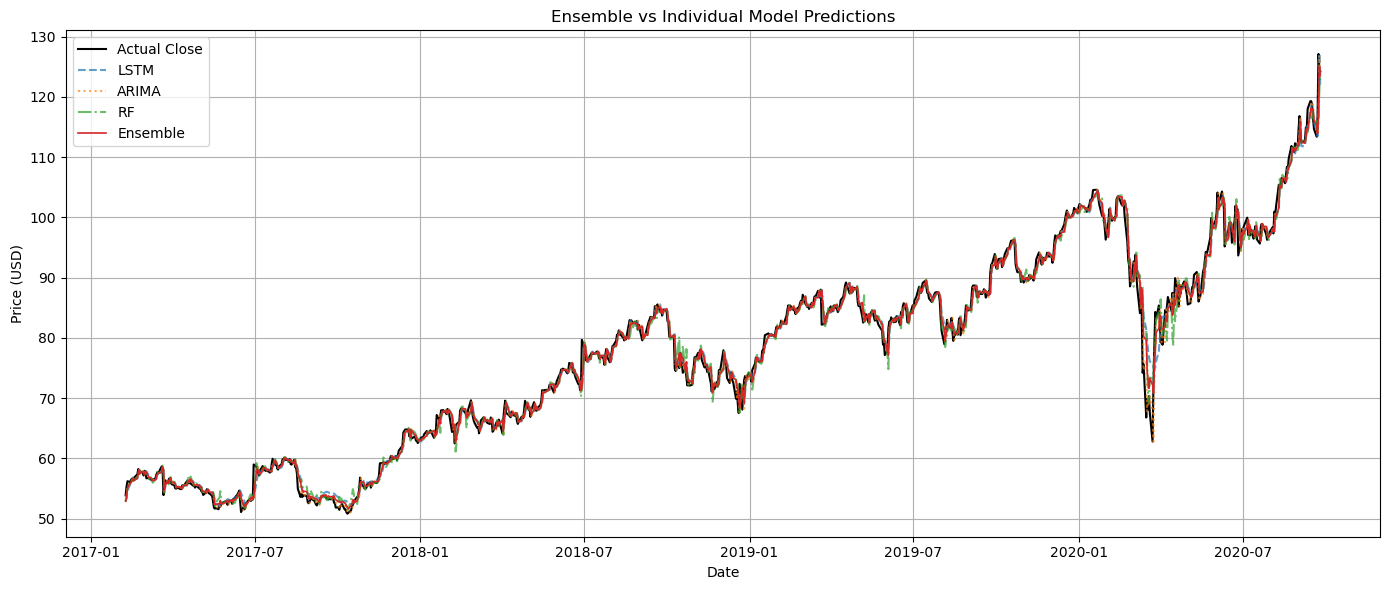

Saved merged predictions to 'merged_model_predictions.csv'


In [122]:
# =====================================================================================================
# === STEP 13: Evaluate all models via RMSE & R² / Evaluation aller Modelle über RMSE sowie R²-Score===
# =====================================================================================================
y_true        = merged["Close"]
rmse_lstm     = mean_squared_error(y_true, merged["LSTM"], squared=False)
rmse_arima    = mean_squared_error(y_true, merged["ARIMA"], squared=False)
rmse_rf       = mean_squared_error(y_true, merged["RF"],   squared=False)
rmse_ensemble = mean_squared_error(y_true, merged["Ensemble"], squared=False)

r2_lstm       = r2_score(y_true, merged["LSTM"])
r2_arima      = r2_score(y_true, merged["ARIMA"])
r2_rf         = r2_score(y_true, merged["RF"])
r2_ensemble   = r2_score(y_true, merged["Ensemble"])

print("\n RMSE comparison:")
print(f"  LSTM     : {rmse_lstm:.4f} USD")
print(f"  ARIMA    : {rmse_arima:.4f} USD")
print(f"  RF       : {rmse_rf:.4f} USD")
print(f"  Ensemble : {rmse_ensemble:.4f} USD")

print("\n R² comparison:")
print(f"  LSTM     : {r2_lstm:.4f}")
print(f"  ARIMA    : {r2_arima:.4f}")
print(f"  RF       : {r2_rf:.4f}")
print(f"  Ensemble : {r2_ensemble:.4f}")



# ===============================================================================================
# === STEP 14: Plot predictions  / Graphische Darstellung der Vorhersagen =======================
# ===============================================================================================
plt.figure(figsize=(14, 6))
plt.plot(merged["Date"], merged["Close"],    label="Actual Close", color="black")
plt.plot(merged["Date"], merged["LSTM"],     label="LSTM",  linestyle="--", alpha=0.7)
plt.plot(merged["Date"], merged["ARIMA"],    label="ARIMA", linestyle=":",  alpha=0.7)
plt.plot(merged["Date"], merged["RF"],       label="RF",    linestyle="-.", alpha=0.7)
plt.plot(merged["Date"], merged["Ensemble"], label="Ensemble", linewidth=1.2)
plt.title("Ensemble vs Individual Model Predictions")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



# ===============================================================================================
# === STEP 15: Export merged predictions / Speicherung der Vorhersagen ==========================
# ===============================================================================================
merged.to_csv("merged_model_predictions.csv", index=False)
print("Saved merged predictions to 'merged_model_predictions.csv'")

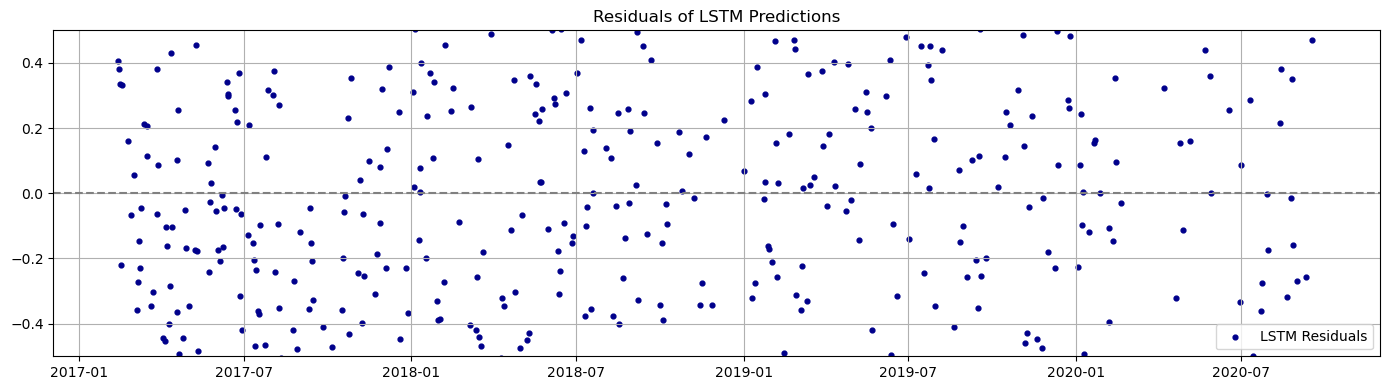

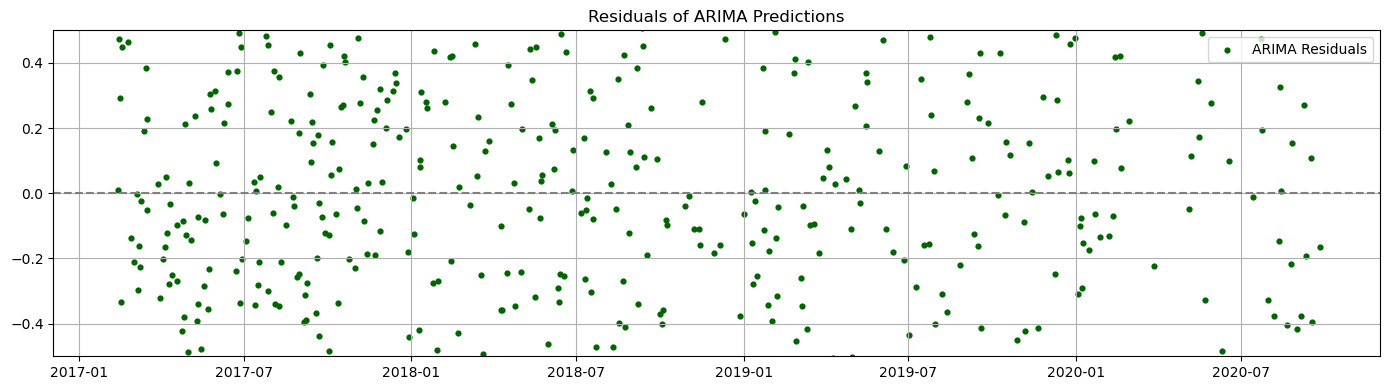

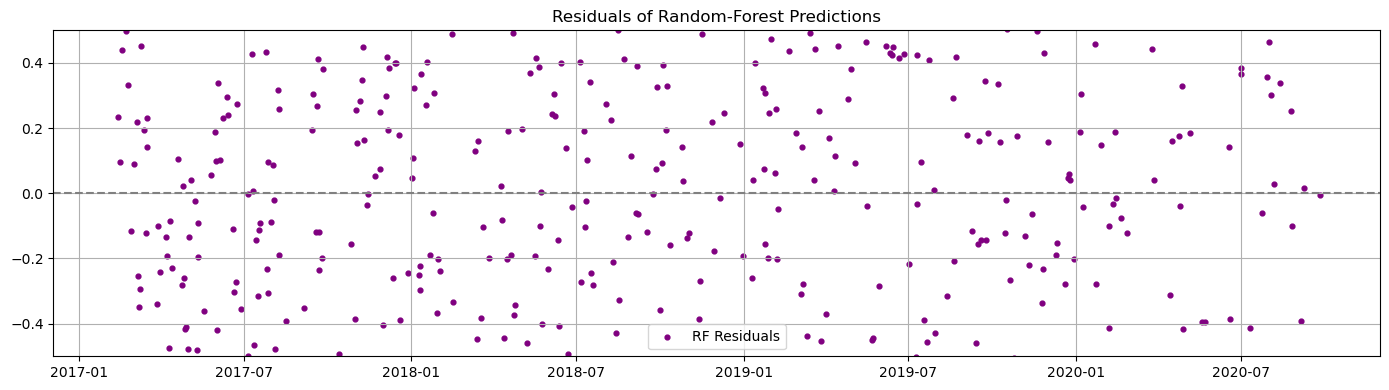

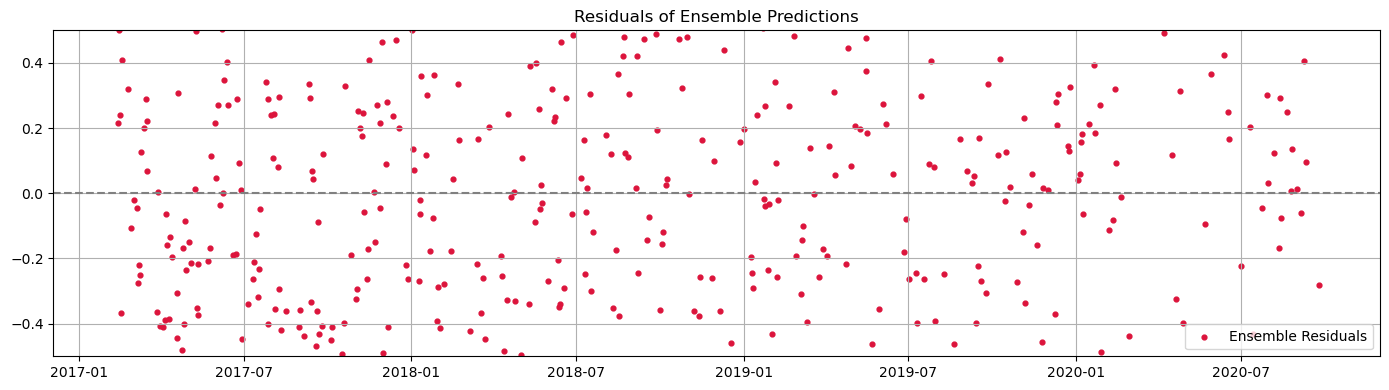


Naive LSTM Residual Analysis / Naive Residuenanalyse des LSTM-Modells:
  Mean of residuals : μ = -0.1032
  Std. deviation    : σ = 1.7791
  95% confidence interval : [-3.4871, 3.4871]
  881 out of 915 residuals (96.28%) within 95% confidence interval.

Naive ARIMA Residual Analysis / Naive Residuenanalyse des ARIMA-Modells:
  Mean of residuals : μ = 0.0326
  Std. deviation    : σ = 1.5215
  95% confidence interval : [-2.9822, 2.9822]
  870 out of 915 residuals (95.08%) within 95% confidence interval.

Naive RF Residual Analysis / Naive Residuenanalyse des RF-Modells:
  Mean of residuals : μ = -0.0127
  Std. deviation    : σ = 1.8153
  95% confidence interval : [-3.5580, 3.5580]
  871 out of 915 residuals (95.19%) within 95% confidence interval.

Naive Ensemble Residual Analysis / Naive Residuenanalyse des Ensemble-Modells:
  Mean of residuals : μ = -0.0277
  Std. deviation    : σ = 1.5949
  95% confidence interval : [-3.1261, 3.1261]
  872 out of 915 residuals (95.30%) within 95% conf

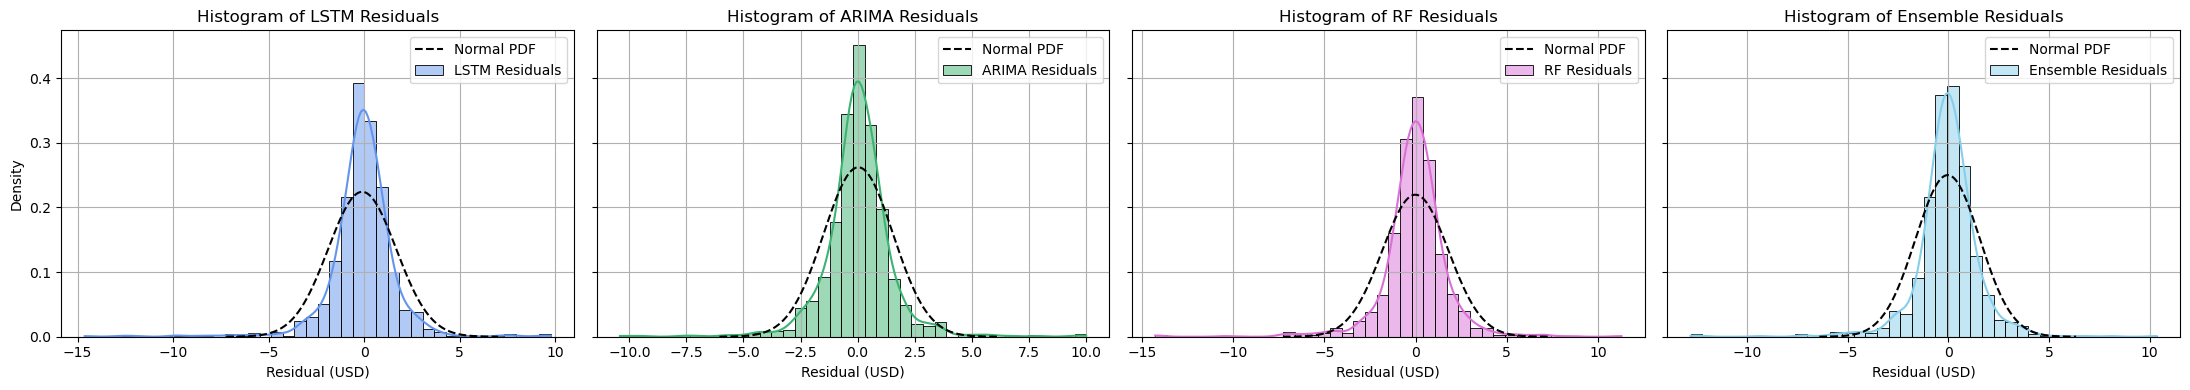

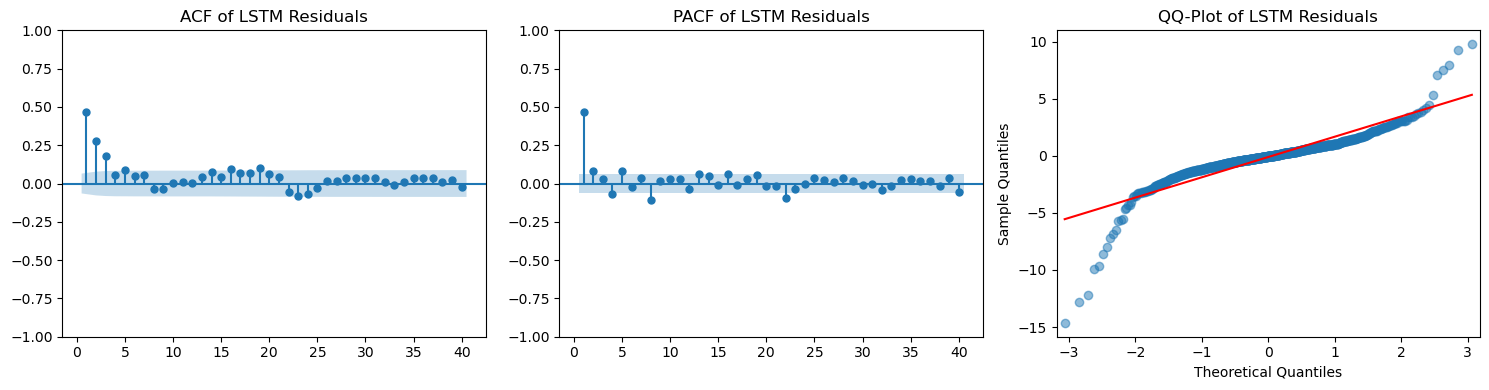

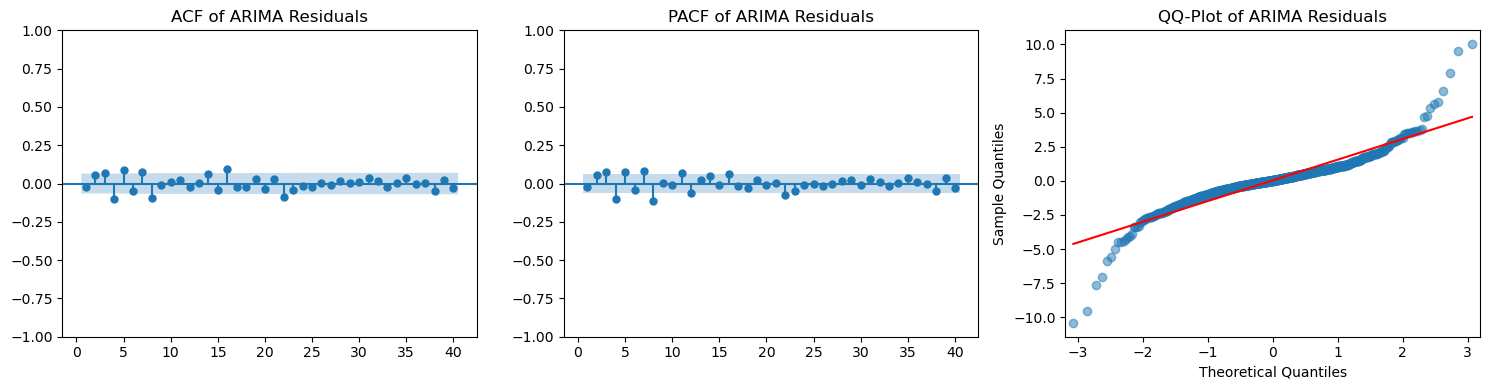

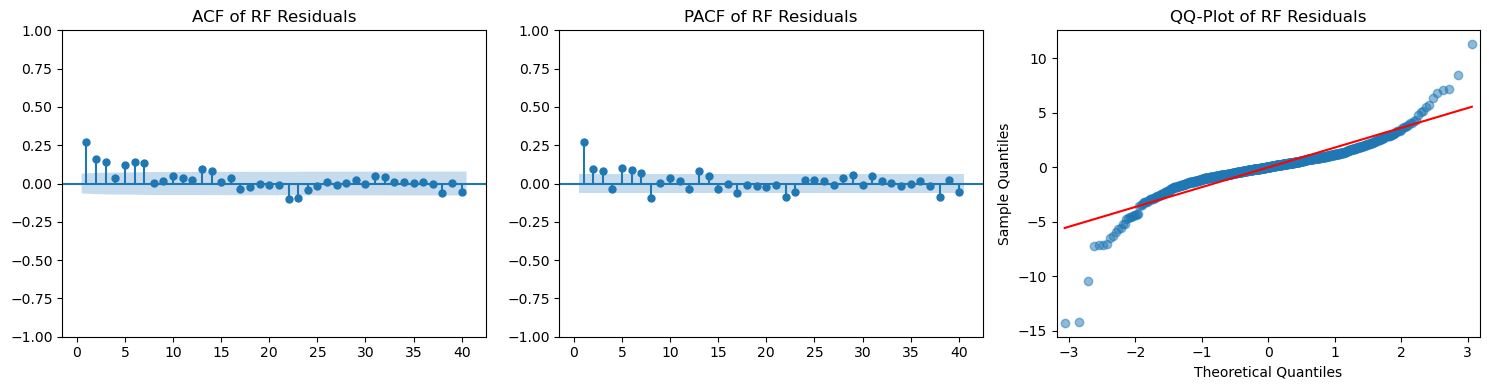

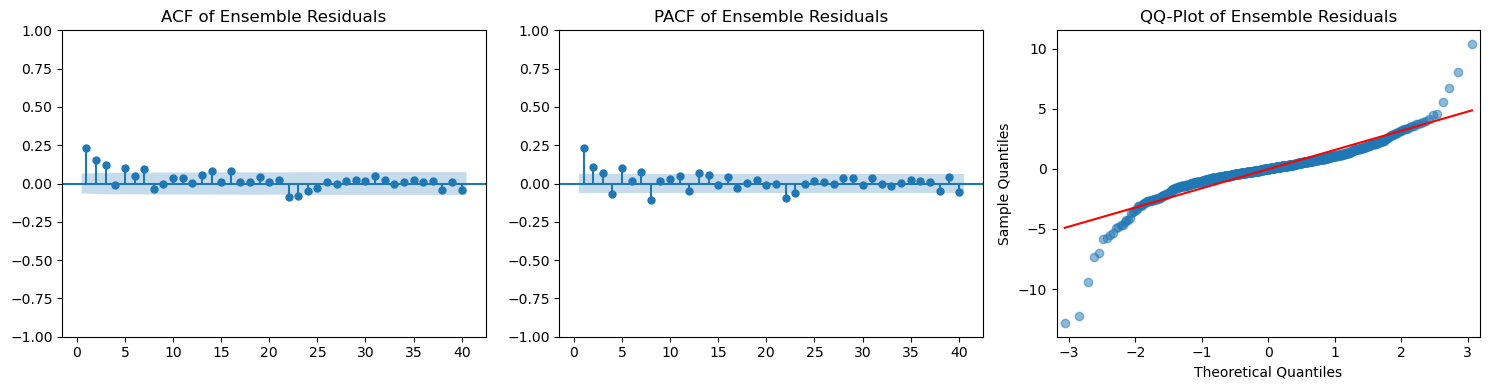


Ljung-Box test (LSTM residuals):
       lb_stat     lb_pvalue
10  315.120888  9.841046e-62
20  354.103705  6.353589e-63
30  373.694027  5.589776e-61
40  380.283743  4.844631e-57
→ Reject H₀: residuals exhibit significant autocorrelation.

Shapiro-Wilk test (LSTM residuals):
W = 0.8189, p = 0.0000
→ Reject H₀: residuals are **not** normally distributed.

Wilcoxon signed-rank test (median = 0, LSTM residuals):
W = 200810.0000, p = 0.2752
→ Fail to reject H₀: median of residuals does not differ from 0.

Ljung-Box test (ARIMA residuals):
      lb_stat  lb_pvalue
10  40.756458   0.000012
20  58.314140   0.000013
30  68.992396   0.000066
40  75.616118   0.000566
→ Reject H₀: residuals exhibit significant autocorrelation.

Shapiro-Wilk test (ARIMA residuals):
W = 0.8728, p = 0.0000
→ Reject H₀: residuals are **not** normally distributed.

Wilcoxon signed-rank test (median = 0, ARIMA residuals):
W = 200206.0000, p = 0.2434
→ Fail to reject H₀: median of residuals does not differ from 0.

Ljun

In [124]:
# ===============================================================================================
# === STEP 16: Residual analysis & diagnostics / Residuenanalyse & Diagnostik ==================
# ===============================================================================================

# Compute residuals / Berechnung der Residuen
lstm_residuals     = merged["Close"] - merged["LSTM"]
arima_residuals    = merged["Close"] - merged["ARIMA"]
rf_residuals       = merged["Close"] - merged["RF"]      
ensemble_residuals = merged["Close"] - merged["Ensemble"]

# --- Scatter plots of the residuals / Plots der Residuen ---------------------------------------
plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], lstm_residuals,  color="darkblue",   s=12, label="LSTM Residuals")
plt.axhline(0, linestyle="--", color="gray"); plt.ylim(-0.5, 0.5)
plt.title("Residuals of LSTM Predictions"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], arima_residuals, color="darkgreen",  s=12, label="ARIMA Residuals")
plt.axhline(0, linestyle="--", color="gray"); plt.ylim(-0.5, 0.5)
plt.title("Residuals of ARIMA Predictions"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], rf_residuals,    color="purple",     s=12, label="RF Residuals")   # ← NEW
plt.axhline(0, linestyle="--", color="gray"); plt.ylim(-0.5, 0.5)
plt.title("Residuals of Random-Forest Predictions"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], ensemble_residuals, color="crimson", s=12, label="Ensemble Residuals")
plt.axhline(0, linestyle="--", color="gray"); plt.ylim(-0.5, 0.5)
plt.title("Residuals of Ensemble Predictions"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# --- Naive residual statistics (LSTM, ARIMA, RF and Ensemble) / Naive Statistik der Residuen --
def naive_stats(name, res):
    mean_r, std_r = res.mean(), res.std()
    lower, upper  = -1.96 * std_r, 1.96 * std_r
    within        = ((res >= lower) & (res <= upper)).sum()
    total         = len(res); pct = within / total * 100
    print(f"\nNaive {name} Residual Analysis / Naive Residuenanalyse des {name}-Modells:")
    print(f"  Mean of residuals : μ = {mean_r:.4f}")
    print(f"  Std. deviation    : σ = {std_r:.4f}")
    print(f"  95% confidence interval : [{lower:.4f}, {upper:.4f}]")
    print(f"  {within} out of {total} residuals ({pct:.2f}%) within 95% confidence interval.")

for tag, res in [("LSTM", lstm_residuals), ("ARIMA", arima_residuals),
                 ("RF",   rf_residuals),   ("Ensemble", ensemble_residuals)]:
    naive_stats(tag, res)


# --- Histograms of the residuals / Histogramme der Residuen ------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(22, 4), sharey=True)
for ax, res, col, title in zip(
        axes,
        [lstm_residuals, arima_residuals, rf_residuals, ensemble_residuals],
        ["cornflowerblue", "mediumseagreen", "orchid", "skyblue"],
        ["LSTM", "ARIMA", "RF", "Ensemble"]):
    sns.histplot(res, bins=40, kde=True, stat="density", color=col, ax=ax, label=f"{title} Residuals")
    mu, sd = res.mean(), res.std()
    x_vals = np.linspace(mu - 4*sd, mu + 4*sd, 200)
    ax.plot(x_vals, norm.pdf(x_vals, mu, sd), linestyle="--", color="black", label="Normal PDF")
    ax.set_title(f"Histogram of {title} Residuals")
    ax.set_xlabel("Residual (USD)"); ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


# --- ACF / PACF / QQ plots ---------------------------------------------------------------------
def triple_plot(res, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plot_acf(res,  lags=40, zero=False, alpha=0.05, ax=axes[0]); axes[0].set_title(f"ACF of {title} Residuals")
    plot_pacf(res, lags=40, zero=False, alpha=0.05, method="ywm", ax=axes[1]); axes[1].set_title(f"PACF of {title} Residuals")
    sm.qqplot(res, line="s", alpha=0.5, ax=axes[2]); axes[2].set_title(f"QQ-Plot of {title} Residuals")
    plt.tight_layout(); plt.show()

for tag, res in [("LSTM", lstm_residuals), ("ARIMA", arima_residuals),
                 ("RF", rf_residuals), ("Ensemble", ensemble_residuals)]:
    triple_plot(res, tag)


# --- Ljung-Box, Shapiro-Wilk & Wilcoxon tests --------------------------------------------------
def diag_tests(name, res):
    print(f"\nLjung-Box test ({name} residuals):")
    lb_df = acorr_ljungbox(res, lags=[10, 20, 30, 40], return_df=True)
    print(lb_df)
    if lb_df["lb_pvalue"].iloc[-1] < 0.05:
        print("→ Reject H₀: residuals exhibit significant autocorrelation.")
    else:
        print("→ Fail to reject H₀: residuals resemble white noise.")

    print(f"\nShapiro-Wilk test ({name} residuals):")
    W, p_sw = shapiro(res)
    print(f"W = {W:.4f}, p = {p_sw:.4f}")
    if p_sw < 0.05:
        print("→ Reject H₀: residuals are **not** normally distributed.")
    else:
        print("→ Fail to reject H₀: residuals appear normally distributed.")

    print(f"\nWilcoxon signed-rank test (median = 0, {name} residuals):")
    W_wilc, p_wilc = wilcoxon(res)
    print(f"W = {W_wilc:.4f}, p = {p_wilc:.4f}")
    if p_wilc < 0.05:
        print("→ Reject H₀: median of residuals differs significantly from 0.")
    else:
        print("→ Fail to reject H₀: median of residuals does not differ from 0.")

for tag, res in [("LSTM", lstm_residuals), ("ARIMA", arima_residuals),
                 ("RF", rf_residuals), ("Ensemble", ensemble_residuals)]:
    diag_tests(tag, res)

## Conclusion

The **Random Forest** under-performs the specialist time-series models: its RMSE ($3.23$ USD) is more than double that of the LSTM and ARIMA, and its R² ($0.96$) lags behind their $\sim 0.99$, indicating weaker out-of-sample explanatory power.

Residual diagnostics reinforce this point: RF errors show the largest standard deviation ($\sigma \approx 3.21$) and the strongest residual autocorrelation (Ljung-Box $p \approx 0$), signalling that the model (unsurprisingly) fails to capture important temporal dependence. Its residuals are also biased (Wilcoxon $p < 0.05$) and strongly non-normal (Shapiro $p \approx 0$), whereas ARIMA residuals remain median-unbiased and less dispersed.

The simple mean-stacking ensemble mitigates some individual weaknesses, but its RMSE ($1.87$ USD) and R² ($0.987$) sit between the best (ARIMA) and the worst (RF), showing that naïvely adding the RF actually drags average performance down. Ensemble residuals inherit significant autocorrelation, suggesting that combining forecasts without accounting for dependence structures does not rectify RF’s shortcomings.

Hence, in this setting a Random Forest offers little incremental value for one-step stock-price prediction and its inclusion in an equally weighted ensemble is not justified without more sophisticated weighting or feature engineering.